<a href="https://colab.research.google.com/github/ric-colasanti/ASPIREColab/blob/main/OOPShiNetworkModelCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import json
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import networkx as nx
import matplotlib.pyplot as plt
import math
import requests
import csv

In [47]:
url = "https://ric-colasanti.github.io/ASPIREColab/Data/2009data.csv"
data = requests.get(url)
lines = data.content.decode('utf-8')
cr = csv.reader(lines.splitlines(), delimiter=',')
shi_2009 = list(cr)
print(shi_2009[0])

print(len(shi_2009))

['2', '58', '1.593', '64.2', '8.71952172', '5.50015284', '57.2']
2197


In [48]:
class Person:
    T_PA = 0.12
    T_EI = 0.07
    def __init__(self,key,data):
        self.id = key
        self.gender = int(data[0])
        self.age = int(data[1])
        self.height = float(data[2])
        self.BW = float(data[3])
        self.start_BW = self.BW
        self.EI = float(data[4])
        self.BEE = float(data[5])
        self.BW_2011 = float(data[6])
        self.BMI = self.BW/(self.height * self.height)
        self.BEE_calc = self.calc_BEE()
        self.linked = []
        self.is_part = False
        self.can_choose = False
        self.xpos =rnd.random()
        self.ypos =rnd.random()
        self.EE = 0.0 # Energy expenditure
        self.PA = 0.0 # Physical activity
        self.Env = 1.0 # Environment
        if self.BMI<18.5:
            self.BMI_catagory = 1
        elif self.BMI>=18.5 and self.BMI<24:
            self.BMI_catagory = 2
        elif self.BMI>=24 and self.BMI<28:
            self.BMI_catagory = 3
        else:
            self.BMI_catagory = 4
        

    def calc_BEE(self):
        if self.gender ==1:
            self.BEE = ((66.5 + 13.6 * self.BW + 500 * self.height - 6.8 * self.age) * 4186 / 1000000) 
        else:
            self.BEE = ((655.1 + 9.5 * self.BW + 180 * self.height - 4.1 * self.age)* 4186 / 1000000) 

    def diffuse_behavior(self):# the calculation of influence and EI/PA change
        inf_PA = 0
        inf_EI = 0
        temp = 0
        s  = 0
        inf_PA_Env = 0
        inf_EI_Env = 0

        for agent in self.linked:
            temp =  agent.PA - self.PA
            s += temp
  
        inf_PA  = (1 / len(self.linked))  * s

        temp = 0
        s  = 0
        for agent in self.linked:
            temp  = agent.EI - self.EI
            s += temp

        inf_EI  = (1 / len(self.linked))  * s

        if inf_PA >= 0:
            inf_PA_Env = inf_PA * self.Env
        else:
            inf_PA_Env = inf_PA / self.Env

        if inf_EI < 0:
            inf_EI_Env = inf_EI * self.Env
        else:
            inf_EI_Env = inf_EI / self.Env

        if (inf_PA_Env > 0) and (abs(inf_PA_Env) > Person.T_PA * self.PA):
            self.PA *= (1 + 0.05)
        if (inf_PA_Env < 0) and (abs(inf_PA_Env) > Person.T_PA * self.PA):
            self.PA *= (1 - 0.05)

        if (inf_EI_Env > 0) and (abs(inf_EI_Env) > Person.T_EI * self.EI):
            self.EI *= (1 + 0.05)
        if (inf_EI_Env < 0) and (abs(inf_EI_Env) > Person.T_EI * self.EI):
            self.EI *= (1 - 0.05) 
    
    def update(self):#the calculation of BW change
        EBI = 0
        self.EE = self.BEE + 0.1 * self.EI + self.PA
        EIB = 7 * (self.EI - self.EE) / 5
        self.BW += (EIB / (7 * math.log(self.BW + 1) + 5))
        self.calc_BEE()
    def distance(self,agent):
        x_sqr = abs(self.xpos-agent.xpos)
        x_sqr*=x_sqr
        y_sqr = abs(self.ypos-agent.ypos)
        y_sqr*=y_sqr
        return math.sqrt(x_sqr*y_sqr)

In [49]:
class Population:
    def __init__(self,selected_population):
        
        self.persons = []
        self.npos ={}
        self.colors=[]

        self.graph = nx.Graph(directed=False)
        bcolors=["white","red","green","blue","yellow"]
        for i in range(len(selected_population)):
            new_person = Person(i,selected_population[i])
            self.graph.add_node(new_person.id)
            self.npos[new_person.id]=(new_person.xpos,new_person.ypos)
            self.colors.append(bcolors[new_person.BMI_catagory])
            self.persons.append(new_person)  
         

    def makeLink(self,agent,choice):
        if self.graph.has_edge(agent.id,choice.id)==False:
            self.graph.add_edge(agent.id,choice.id)
            choice.linked.append(agent)
            agent.linked.append(choice)
        #choice.linked.append(agent)
        #     return True
        # return False
        

    def linkAgentTo(self,agent):
        
        candidate = list(filter(self.chosen_not_self_filter(agent),self.persons))  
        sink_agent = rnd.choice(candidate)
        if rnd.random()>0.2:
            candidate = list(filter(self.homophily_filter(agent),self.persons))
        choicelist =[]
        for agnt in candidate:
            for _ in range(len(agnt.linked)):
                choicelist.append(agnt)
        if len(choicelist)>0 :
            choice = rnd.choice(choicelist)
        else:
            choice = sink_agent

        self.makeLink(agent,choice)
            # if flag and choice in self.not_linked and len(choice.linked_to) >0:
            #     self.not_linked.remove(choice)
        
                
                


    def makeGraph(self,ld = 0.267):                
        i = 0
        while i < len(self.persons):
            linkable = list(filter(self.can_choose_filter(),self.persons))
            if (rnd.random()<=ld) and (len(linkable)>2):
                agent = rnd.choice(linkable)
                self.linkAgentTo(agent)
            else:
                not_linked = list(filter(self.not_chosen_filter(),self.persons))
                agent = rnd.choice(not_linked)
                agent.can_choose = True
                i+=1

        not_linked = list(filter(self.not_linked_to_filter(),self.persons))
        for agent in not_linked:
            self.linkAgentTo(agent)   


    def  homophily_filter(self,agent):
        agent = agent
        def infun(x):
            d = x
            a_d = agent
            if x.can_choose == False:
                return False
            if x == agent:
                return False
            if (d.BMI_catagory == a_d.BMI_catagory ) and (x.gender == agent.gender) and (abs(d.age-a_d.age)<4):
                return True
            elif (x.gender == agent.gender) and (abs(d.age-a_d.age)<4) and (agent.distance(x)<0.2):
                return True
            elif (x.gender == agent.gender) and (d.BMI_catagory == a_d.BMI_catagory) and (agent.distance(x)<0.2):
                return True
            elif (abs(d.age-a_d.age)<4) and (d.BMI_catagory == a_d.BMI_catagory) and (agent.distance(x)<0.2):
                return True
            else:
                return False
        return infun

      

    def not_linked_to_filter(self):  
        def infun(x):
            if len(x.linked) ==0:
                return True
            #if len(x.linked_from) == 0:
            #    return True
            return False
        return infun 

    def chosen_not_self_filter(self,agent):
        agent = agent
        def infun(x):
            if x == agent:
                return False
            elif x.can_choose:
                return True
            return False
        return infun


    def not_chosen_filter(self):
        def infun(x):
            if x.can_choose:
                return False
            return True
        return infun



    def can_choose_filter(self):  
        def infun(x):
            if x.can_choose and x.is_part:
                return True
            return False
        return infun


    def run(self):
        for day in range(365*2):
            if day % 7 == 0:
                for person in self.persons:
                    person.diffuse_behavior()
                    person.update()

In [50]:
population = Population(shi_2009)
population.makeGraph()

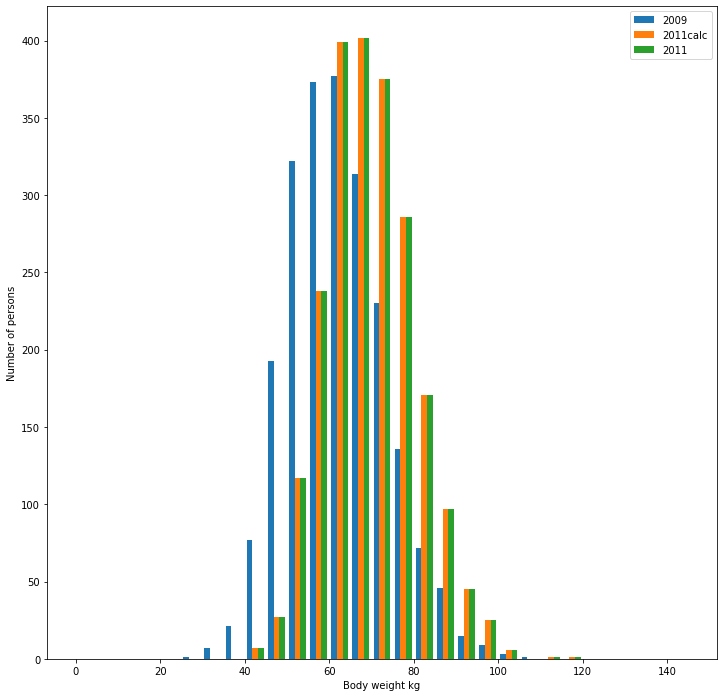

In [51]:
weights2009 = []
weights2011calc = []
weights2011shi = []
population.run()
for person in population.persons:
    weights2009.append(person.start_BW)    
weights_np_2009 = np.array(weights2009)
for person in population.persons:
    weights2011calc.append(person.BW)    
weights_np_2011calc = np.array(weights2011calc)
for person in population.persons:
    weights2011shi.append(person.BW_2011)    
weights_np_2011shi = np.array(weights2011calc)
bins = [x for x in range(0,150,5)]
plt.rcParams["figure.figsize"] = (12,12)
plt.hist([weights_np_2009,weights_np_2011calc,weights_np_2011shi] ,bins=bins,label=["2009","2011calc","2011"])
plt.xlabel("Body weight kg")
plt.ylabel("Number of persons")
plt.legend()
plt.show()

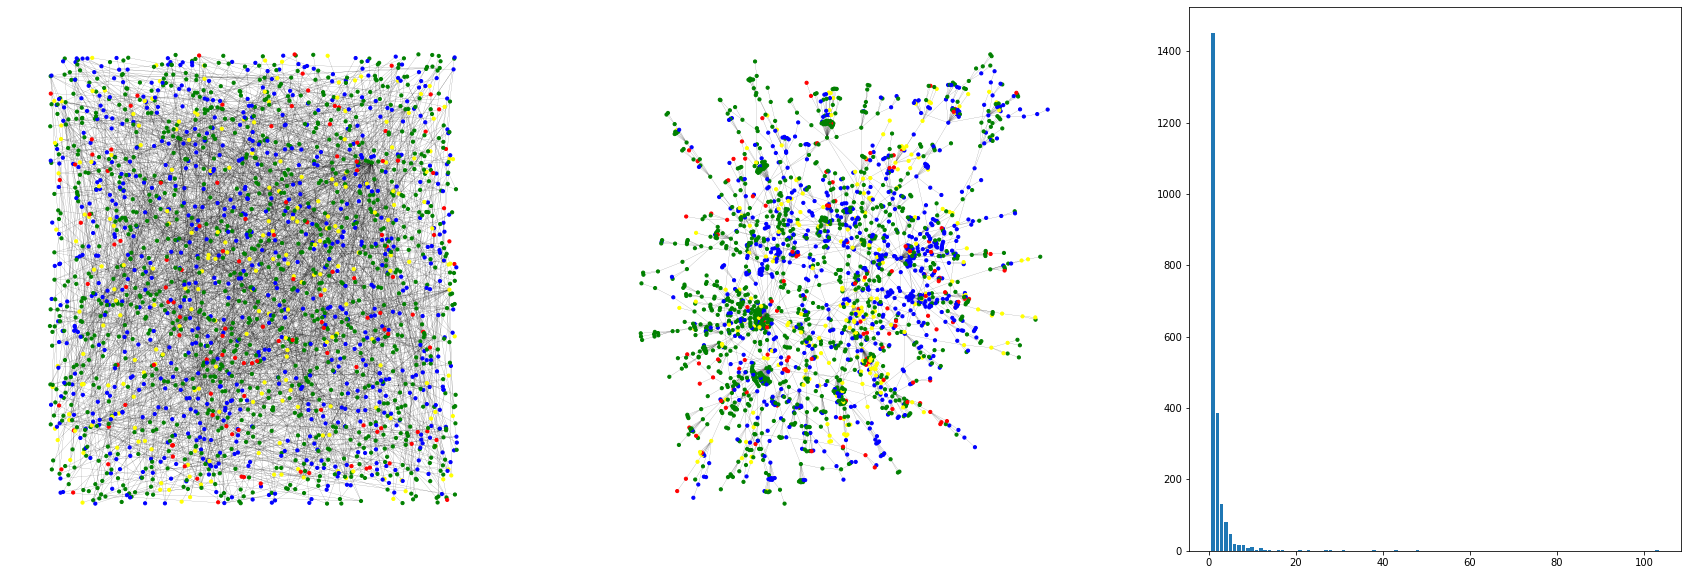

Average shortest path length 11.137846525274986
Average clustering 0.0
number of nodes 2197


In [52]:
gcc = sorted(nx.connected_components(population.graph), key=len, reverse=True)
graph = population.graph.subgraph(gcc[0])
degree_sequence = sorted([d for n, d in population.graph.degree()], reverse=True)
plt.rcParams["figure.figsize"] = (30,10)
plt.subplot(1,3,1)
nx.draw(population.graph,pos=population.npos,node_size=10,node_color=population.colors,width=0.1,arrows=False) 
plt.subplot(1,3,2)
nx.draw(population.graph,node_color=population.colors,node_size=10,width=0.1,arrows=False) 
plt.subplot(1,3,3)
x,y =np.unique(degree_sequence, return_counts=True)
plt.bar(x,y)
#plt.subplot(2,2,4)
#plt.plot()
plt.show()
print("Average shortest path length",nx.average_shortest_path_length(graph))
print("Average clustering",nx.average_clustering(graph))
print("number of nodes", graph.number_of_nodes())